<a href="https://colab.research.google.com/github/HenryJi529/ColabNotebooks/blob/main/PracticePytorch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [ ]:
!pip install torchmetrics
!pip install -U mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchmetrics
from torchmetrics import ConfusionMatrix, Accuracy

import torchvision
from torchvision import datasets
from torchvision import transforms

import mlxtend
from mlxtend.plotting import plot_confusion_matrix

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 400

import time
import datetime 
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## 1. What are 3 areas in industry where computer vision is currently being used?

1. self-driving
2. healthcare imaging
3. security

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

Overfitting is an undesirable machine learning behavior that occurs when the machine learning model gives accurate predictions for training data but not for new data. 

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

- 正则化
- 简化模型
- 强化数据
- 迁移模型

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [ ]:
# Get the MNIST train dataset 
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
) # do we want to transform the data as we download it? 

# Get the MNIST test dataset
test_data = datasets.MNIST(
    root="data",
    train=False, 
    download=True,
    transform=transforms.ToTensor()
) 

In [ ]:
class_names = train_data.classes
CLASS_NUM = len(class_names)
class_to_idx = train_data.class_to_idx
class_names, class_to_idx

(['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 {'0 - zero': 0,
  '1 - one': 1,
  '2 - two': 2,
  '3 - three': 3,
  '4 - four': 4,
  '5 - five': 5,
  '6 - six': 6,
  '7 - seven': 7,
  '8 - eight': 8,
  '9 - nine': 9})

In [ ]:
sample = train_data[0]
image, label = sample
image.shape, label, len(train_data), len(test_data), len(class_names)

(torch.Size([1, 28, 28]), 5, 60000, 10000, 10)

## 6. Visualize at least 5 different samples of the MNIST training dataset.

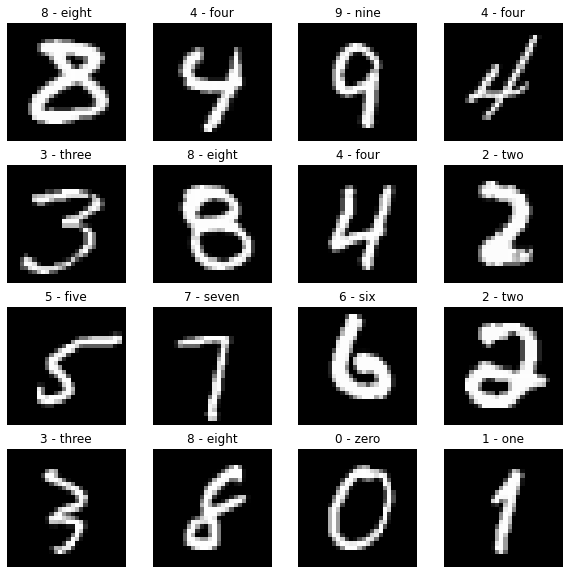

In [ ]:
rows, cols = 4,4
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i in range(rows*cols):
  random_idx = torch.randint(0, len(train_data), size=(1,)).item()
  image, label = train_data[random_idx]
  ax = axes[int(i / cols)][i % cols]
  ax.imshow(image.squeeze(), cmap='gray')
  ax.set_title(class_names[label])
  # ax.yaxis.set_visible(False)
  ax.axis(False)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [ ]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

In [ ]:
batch_size = train_dataloader.batch_size
batch_size, train_dataloader.__len__(), train_dataloader.dataset.__len__()

(32, 1875, 60000)

In [ ]:
X, y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [ ]:
CHANNELS = X.shape[1]
ROWS = X.shape[2]
COLS = X.shape[3]

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [ ]:
class FashionMNISTModel(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_units):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*int(ROWS*COLS/4/4),
                  out_features=output_shape)
    )
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    Z1 = self.conv_block_1(x)
    Z2 = self.conv_block_2(Z1)
    Z3 = self.classifier(Z2)
    return Z3

model = FashionMNISTModel(CHANNELS, CLASS_NUM, 10).to(DEVICE)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               metric_fn: torchmetrics.metric.Metric):
  
  print("Starting Training...")

  train_loss, train_metric = 0, 0

  model.train()

  for batch in tqdm(data_loader):
    X, y = batch
    X, y = X.to(DEVICE), y.to(DEVICE)

    y_logits = model(X)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y)
    metric = metric_fn(y_pred, y)
  
    train_loss += loss
    train_metric += metric

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_metric /= len(data_loader)

  return train_loss.item(), train_metric.item()

In [ ]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               metric_fn: torchmetrics.metric.Metric):

  print("Starting Evaluating...")

  test_loss, test_metric = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(DEVICE), y.to(DEVICE)

      y_logits = model(X)
      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

      test_loss += loss_fn(y_logits, y)
      test_metric += metric_fn(y_pred, y)

    test_loss /= len(test_dataloader)
    test_metric /= len(test_dataloader)

  return test_loss.item(), test_metric.item()

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

accuracy_fn = Accuracy(task="multiclass", num_classes=CLASS_NUM).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

start_time = time.time()
train_losses = []
test_losses = []
train_accs = []
test_accs = []

epochs = 5

for epoch in tqdm(range(epochs)):

  print(f"Epoch {epoch}:")

  train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn)
  test_loss, test_acc = test_step(model, test_dataloader, loss_fn, accuracy_fn)

  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accs.append(train_acc)
  test_accs.append(test_acc)

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")
  print("--------"*10)

end_time = time.time()
during_time = int(end_time - start_time)

print(f"运行时间: {datetime.timedelta(seconds=during_time)}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.1946 | Test Loss: 0.1112 | Train Acc: 93.85% | Test Acc: 96.28%
--------------------------------------------------------------------------------
Epoch 1:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.0964 | Test Loss: 0.0813 | Train Acc: 96.99% | Test Acc: 97.49%
--------------------------------------------------------------------------------
Epoch 2:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.0895 | Test Loss: 0.0833 | Train Acc: 97.25% | Test Acc: 97.27%
--------------------------------------------------------------------------------
Epoch 3:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.0859 | Test Loss: 0.0776 | Train Acc: 97.30% | Test Acc: 97.37%
--------------------------------------------------------------------------------
Epoch 4:
Starting Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

Starting Evaluating...


  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.0843 | Test Loss: 0.0764 | Train Acc: 97.28% | Test Acc: 97.52%
--------------------------------------------------------------------------------
运行时间: 0:01:46


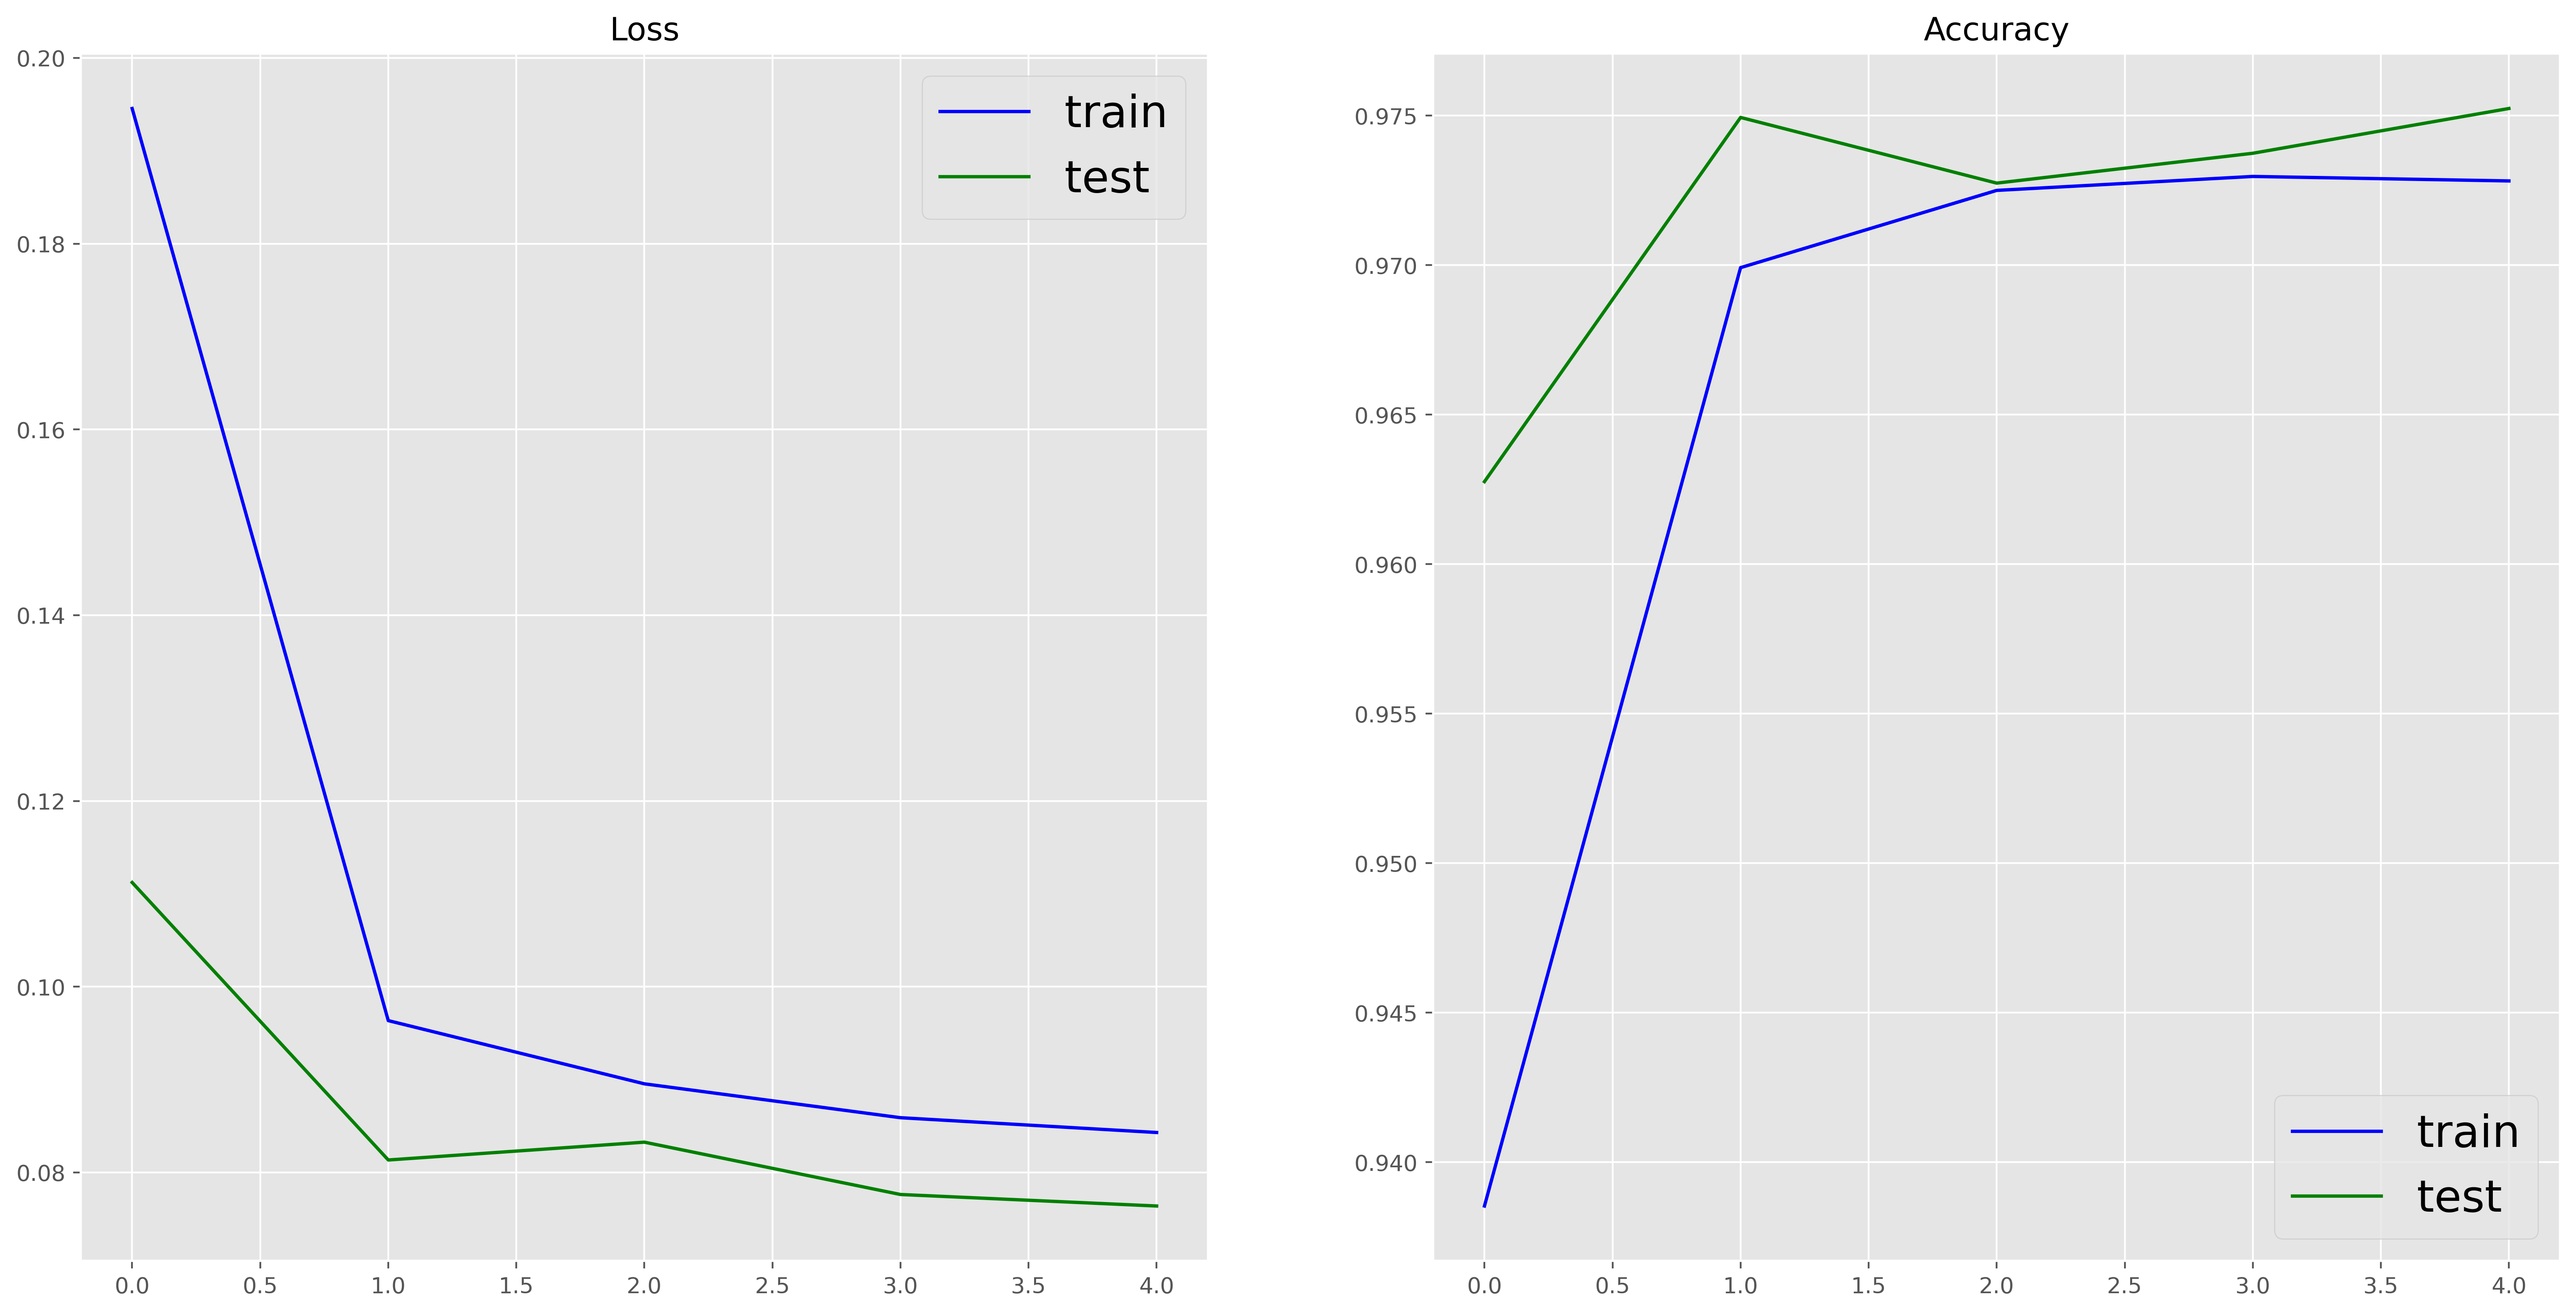

In [ ]:
with plt.style.context('ggplot'):
  fig, axes = plt.subplots(1,2, figsize=(20,10))
  axes[0].plot(train_losses, c='b', label="train")
  axes[0].plot(test_losses, c='g', label="test")
  axes[0].set_title('Loss')
  axes[0].legend(fontsize=20)
  axes[1].plot(train_accs, c='b', label="train")
  axes[1].plot(test_accs, c='g', label="test")
  axes[1].set_title('Accuracy')
  axes[1].legend(fontsize=20)

## 10. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [ ]:
def eval_mode(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
  loss, acc = 0,0
  y_preds = []
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(DEVICE), y.to(DEVICE)

      y_logits = model(X)
      y_pred_prob = torch.softmax(y_logits, dim=1)
      y_pred = y_pred_prob.argmax(dim=1)

      loss += loss_fn(y_logits, y)
      acc += accuracy_fn(y_pred, y)
      y_preds.append(y_pred)
    
    acc /= len(data_loader)
    loss /= len(data_loader)

  return {
      "model_name": model.__class__.__name__,
      "model_loss": loss.item(),
      "model_acc": acc.item(),
      "model_pred": y_preds
  }

model_result = eval_mode(model, test_dataloader, loss_fn, accuracy_fn)
print(f"test_loss: {model_result['model_loss']:.4f} | test_acc: {model_result['model_acc']*100:.2f}")

  0%|          | 0/313 [00:00<?, ?it/s]

test_loss: 0.0764 | test_acc: 97.52


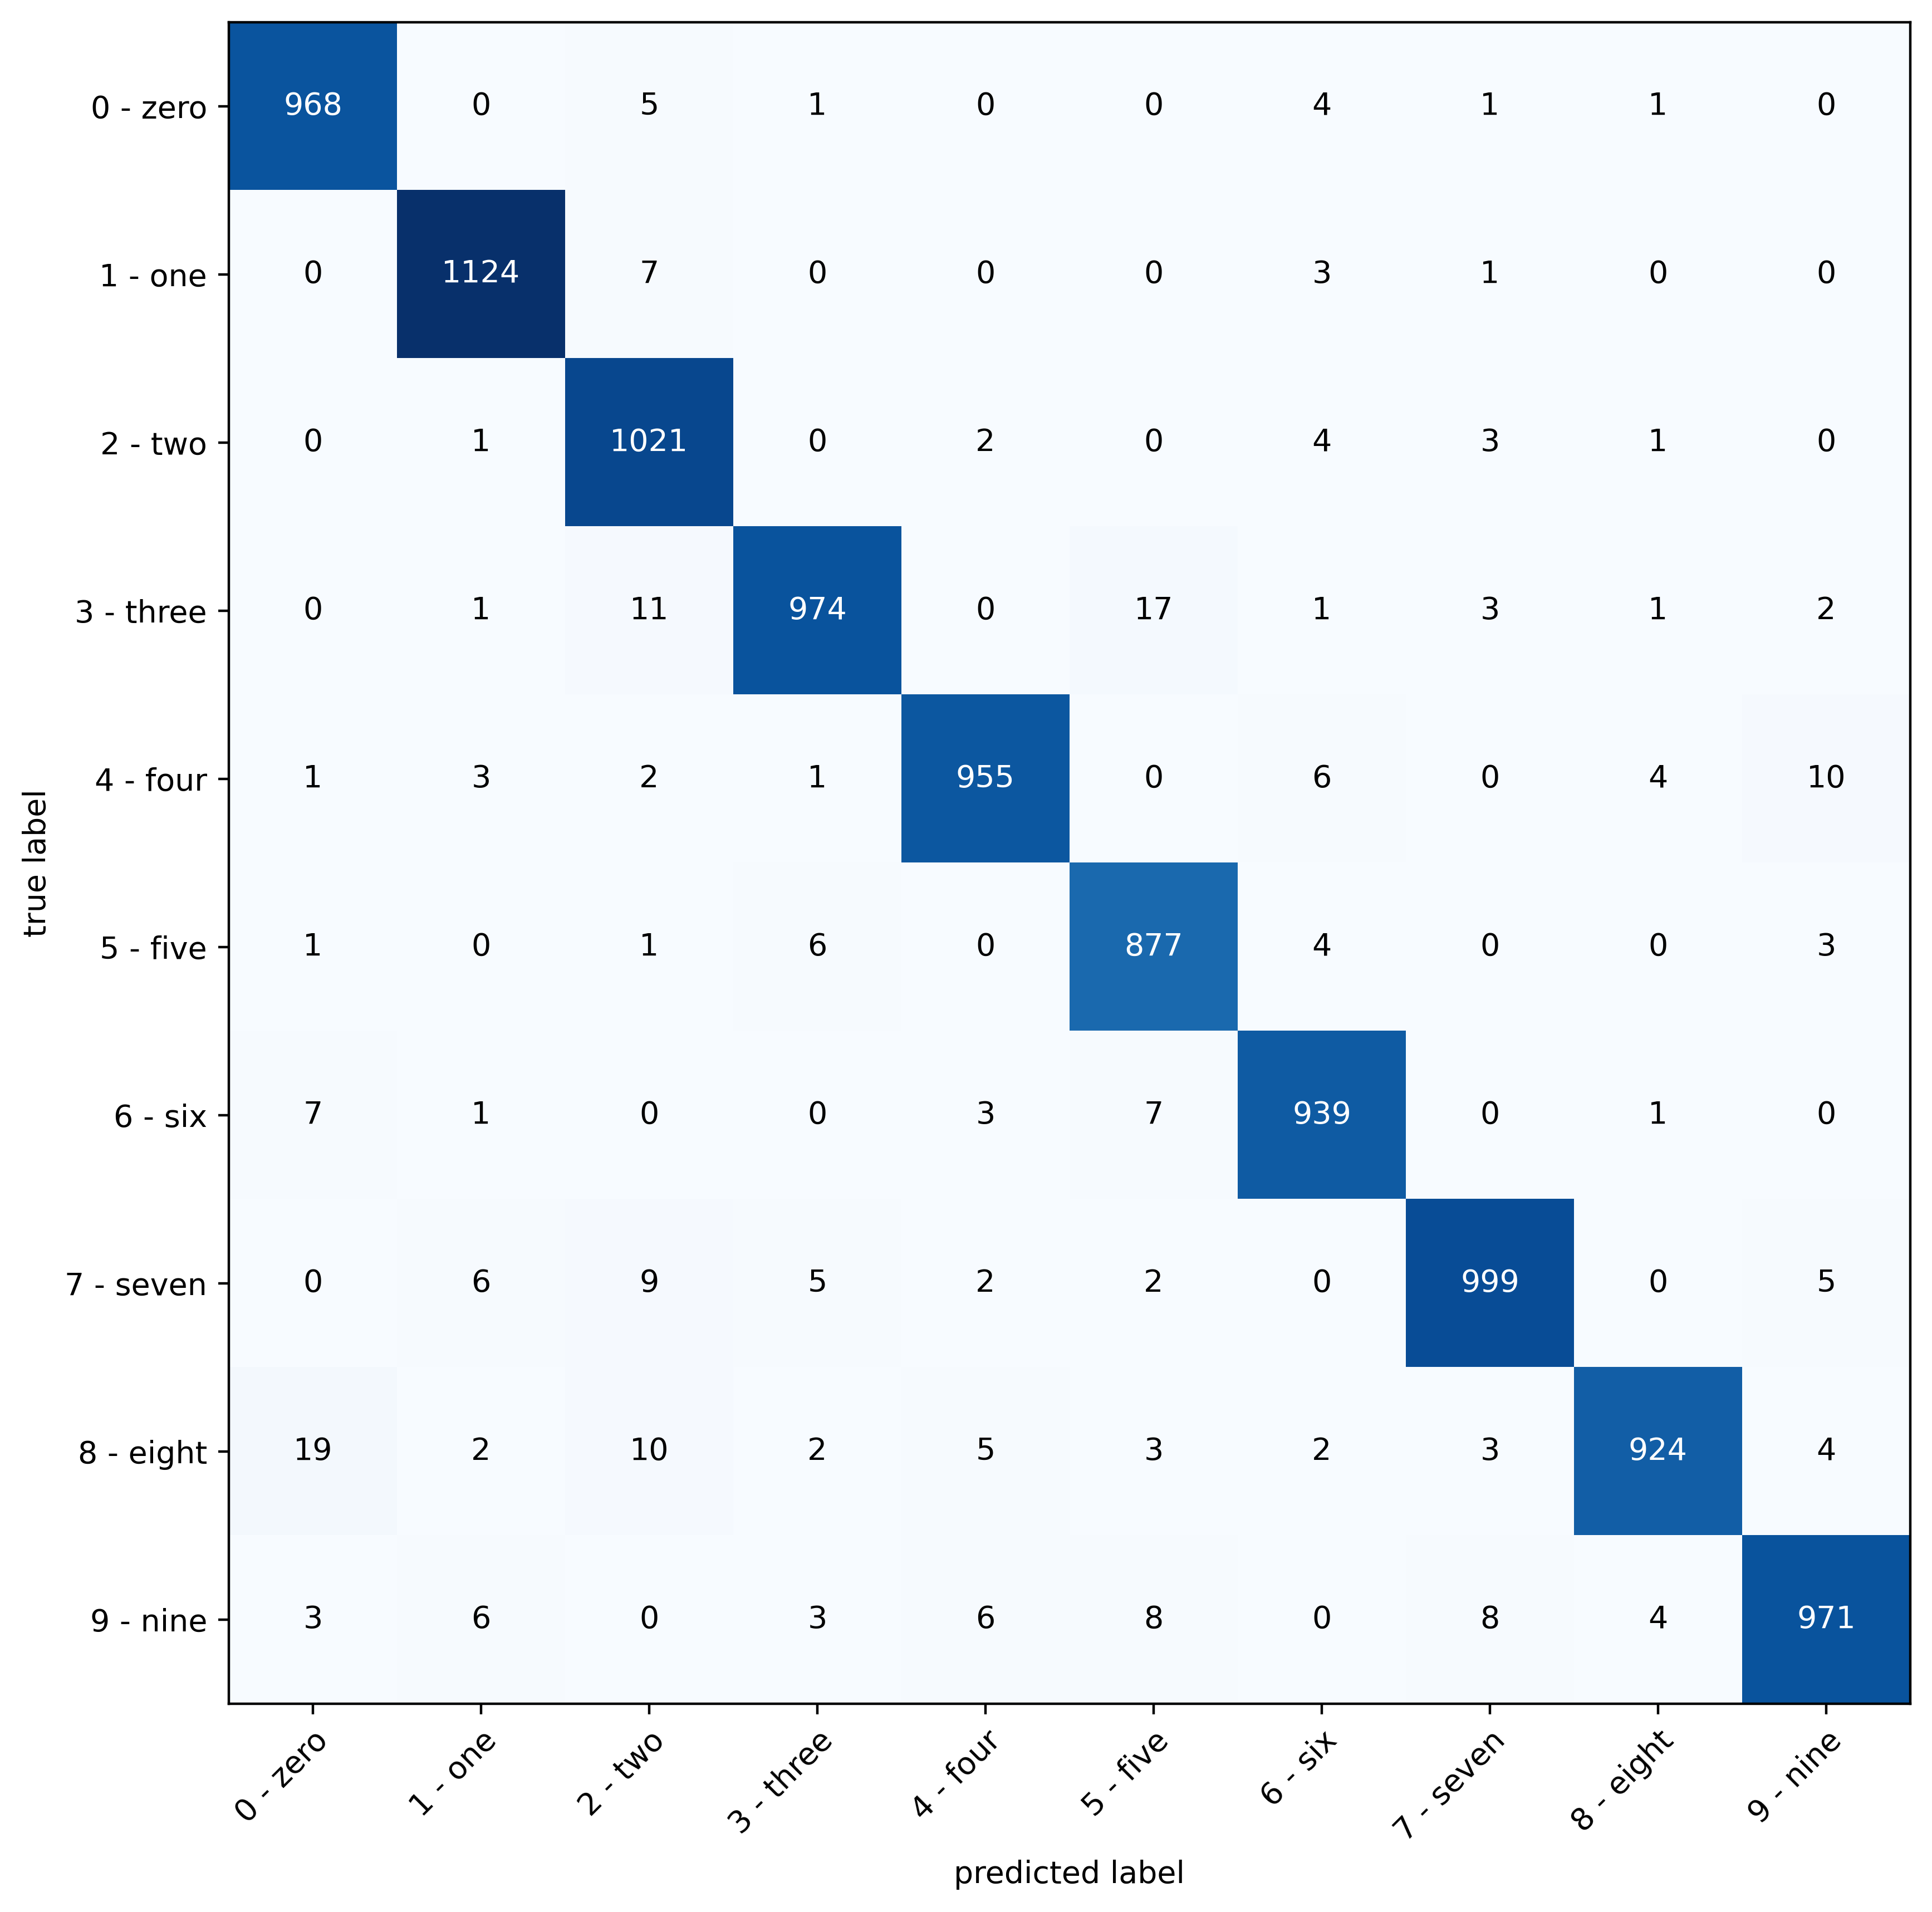

In [ ]:
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass").to(DEVICE)
confmat_tensor = confmat(preds=torch.cat(model_result["model_pred"]), target=test_data.targets.to(DEVICE))
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(),
    class_names=class_names,
    figsize=(10,10)
)

## 11. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

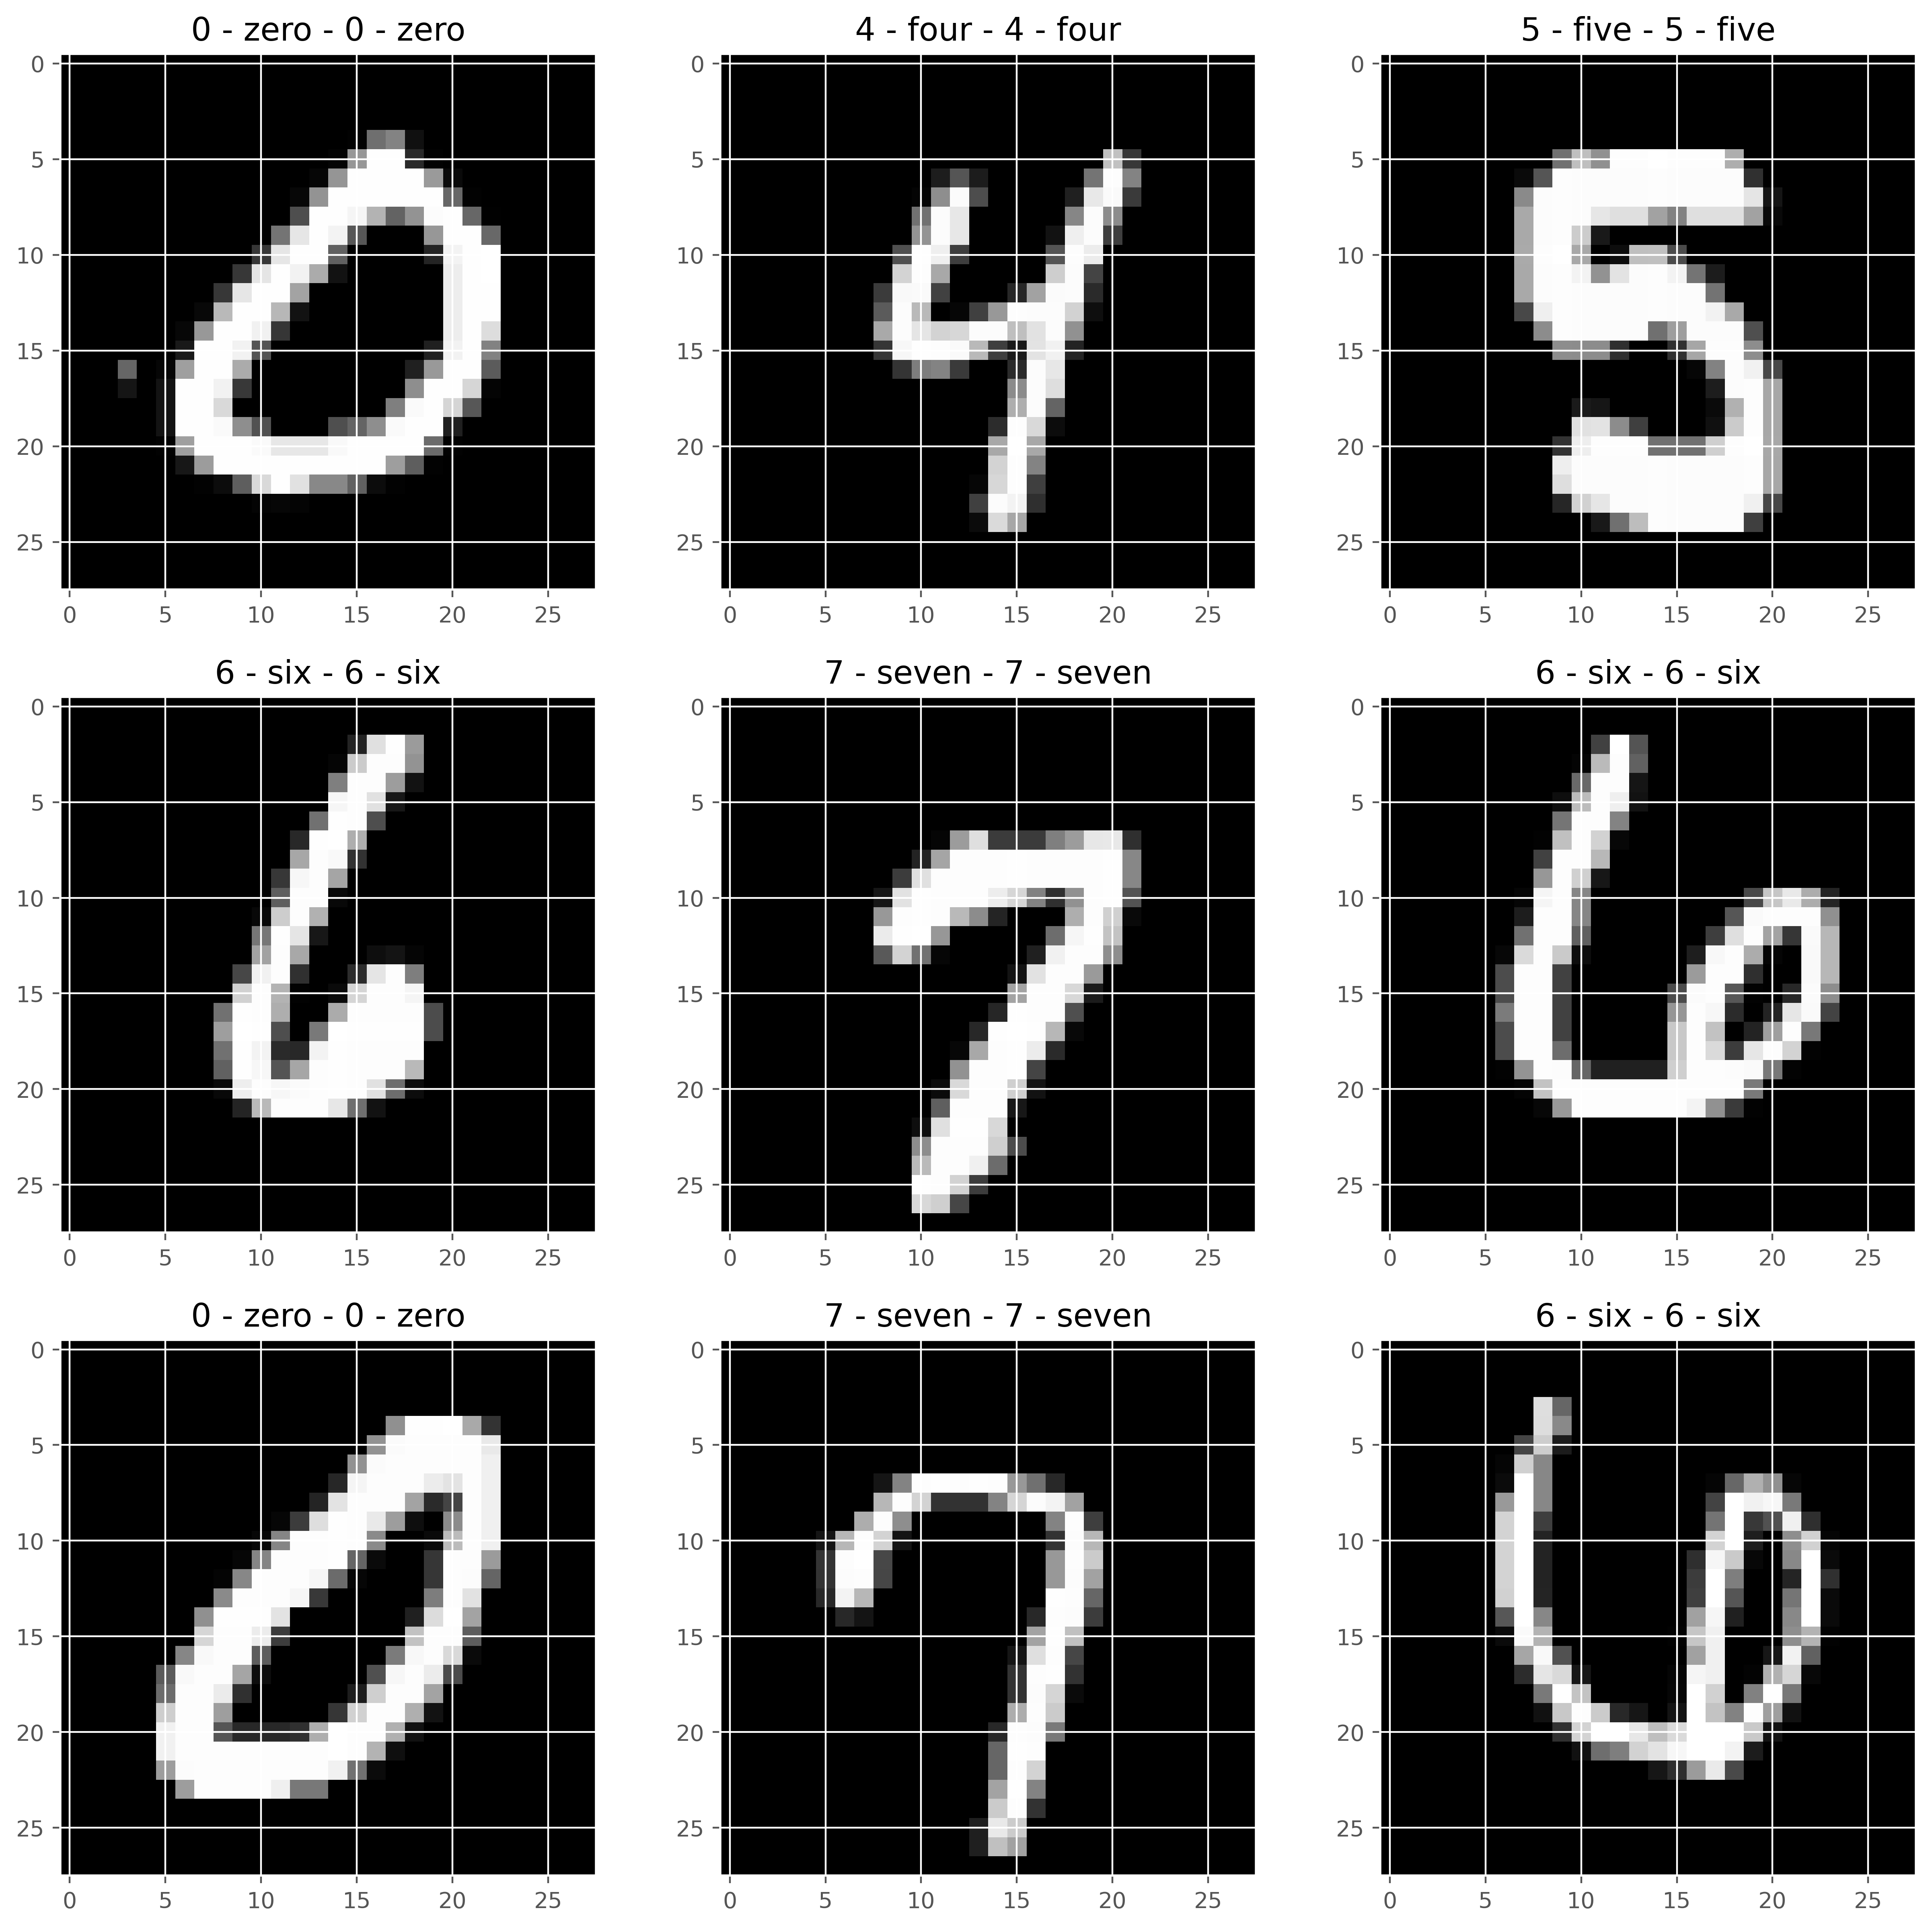

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list):
  pred_labels = []
  model.eval()
  with torch.inference_mode():
    for X in data:
      X = X.unsqueeze(0).to(DEVICE)
      y_logits = model(X)
      y_pred_prob = torch.softmax(y_logits, dim=1)
      y_pred_label = y_pred_prob.argmax(dim=1)
      pred_labels.append(y_pred_label.item())
  return pred_labels

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

pred_labels = make_predictions(model, test_samples)

with plt.style.context('ggplot'):
  fig, axes = plt.subplots(3,3, figsize=(15,15))
  for ind, (sample, true_label, pred_label) in enumerate(zip(test_samples, test_labels, pred_labels)):
    ax = axes[int(ind/3)][ind%3]
    ax.imshow(sample.squeeze(), cmap='gray')
    ax.set_title(f"{class_names[true_label]} - {class_names[pred_label]}")

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [ ]:
tensor1 = torch.rand(1,3,64,64)
conv_layer = nn.Conv2d(3,10, kernel_size=3,stride=1,padding=1)
conv_layer(tensor1).shape

torch.Size([1, 10, 64, 64])